In [51]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import ListedColormap

In [70]:
class AdalineGD(object):
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
    
    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []
        for i in range(self.n_iter):
            # 総入力計算
            net_input = self.net_input(X)
            # 総入力に活性化関数適用
            output = self.activation(net_input)
            # 誤差を計算
            errors = (y - output)
            # 誤差をもとに、重みを計算&&適用
            self.w_[1:] += self.eta * X.T.dot(errors)
            # 誤差をもとに、重みを計算&&適用(バイアス)
            self.w_[0] += self.eta * errors.sum()
            # コスト計算,学習進捗の目安となる
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self
    
    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def activation(self, X):
        return X
    
    def predict(self, X):
        return np.where(self.activation(self.net_input(X)) >= 0.0, 1, -1)

In [76]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header=None)
y = df.iloc[0:100, 4].values
y = np.where(y == 'Iris-setosa', -1, 1)
X = df.iloc[0:100, [0, 2]].values

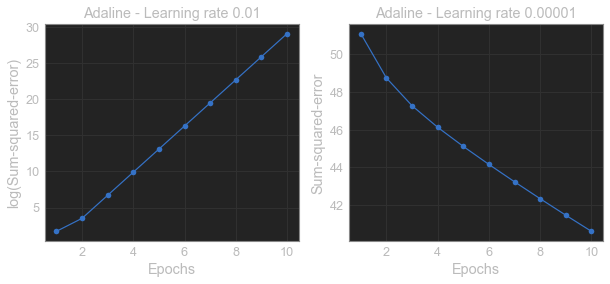

In [78]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
ada1 = AdalineGD(n_iter=10, eta=0.01).fit(X, y)
ax[0].plot(range(1,len(ada1.cost_)+1), np.log10(ada1.cost_), marker='o')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('log(Sum-squared-error)')
ax[0].set_title('Adaline - Learning rate 0.01')
ada2 = AdalineGD(n_iter=10, eta=0.0001).fit(X,y)
ax[1].plot(range(1, len(ada2.cost_)+1), ada2.cost_, marker='o')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Sum-squared-error')
ax[1].set_title('Adaline - Learning rate 0.00001')
plt.show()

In [82]:
X_std = np.copy(X)
X_std[:, 0] = (X[:, 0] - X[:, 0].mean()) / X[:, 0].std()
X_std[:, 1] = (X[:, 1] - X[:, 1].mean()) / X[:, 1].std()

In [83]:
def plot_decision_regions(X, y, classifier, resolution=0.02):
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                                              np.arange(x2_min, x2_max, resolution))
    print(xx1)
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    print(Z)
    Z = Z.reshape(xx1.shape)
    print(Z.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                            y=X[y == cl, 1],
                            alpha=0.8,
                            c=colors[idx],
                            marker=markers[idx],
                            label=classifier,
                            edgecolor='black')

[[-2.8340382 -2.8140382 -2.7940382 ...  3.3459618  3.3659618  3.3859618]
 [-2.8340382 -2.8140382 -2.7940382 ...  3.3459618  3.3659618  3.3859618]
 [-2.8340382 -2.8140382 -2.7940382 ...  3.3459618  3.3659618  3.3859618]
 ...
 [-2.8340382 -2.8140382 -2.7940382 ...  3.3459618  3.3659618  3.3859618]
 [-2.8340382 -2.8140382 -2.7940382 ...  3.3459618  3.3659618  3.3859618]
 [-2.8340382 -2.8140382 -2.7940382 ...  3.3459618  3.3659618  3.3859618]]
[-1 -1 -1 ...  1  1  1]
(243, 312)


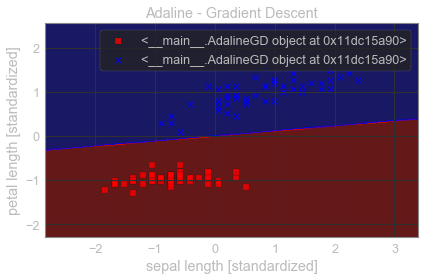

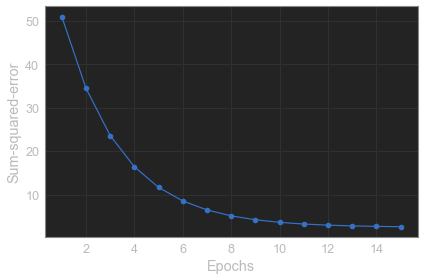

In [84]:
ada = AdalineGD(n_iter=15, eta=0.01)
ada.fit(X_std, y)
plot_decision_regions(X_std, y, classifier=ada)
plt.title('Adaline - Gradient Descent')
plt.xlabel('sepal length [standardized]')
plt.ylabel('petal length [standardized]')
plt.legend(loc='best')
plt.tight_layout()
plt.show()
plt.plot(range(1, len(ada.cost_) + 1), ada.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Sum-squared-error')
plt.tight_layout()
plt.show()

In [85]:
from numpy.random import seed

In [90]:
class AdalineSGD(object):
    def __init__(self, eta=0.01, n_iter=10, shuffle=True, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffleffle = shuffle
        self.random_state = random_state
    
    def fit(self, X, y):
        self._initialize_weights(X.shape[1])
        self.cost_ = []
        for i in range(self.n_iter):
            if self._shuffle:
                X, y = self._shuffle(X, y)
            cost = []
            for xi, target in zip(X, y):
                cost.append(self._update_weights(xi, target))
            avg_cost = sum(cost) / len(y)
            self.cost_.append(avg_cost)
        return self
    
    def partial_fit(self, X, y):
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self
    
    def _shuffle(self, X, y):
        r = self.rgen.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=1 + m)
        self.w_initialized = True
        
    def _update_weights(self, xi, target):
        output = self.activation(self.net_input(xi))
        error = (target - output)
        self.w_[1:] += self.eta * xi.dot(error)
        self.w_[0] += self.eta * error
        cost = 0.5 * error**2
        return cost
    
    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def activation(self, X):
        return X
    
    def predict(self, X):
        return np.where(self.activation(self.net_input(X)) >= 0.0, 1, -1)

[[-2.8340382 -2.8140382 -2.7940382 ...  3.3459618  3.3659618  3.3859618]
 [-2.8340382 -2.8140382 -2.7940382 ...  3.3459618  3.3659618  3.3859618]
 [-2.8340382 -2.8140382 -2.7940382 ...  3.3459618  3.3659618  3.3859618]
 ...
 [-2.8340382 -2.8140382 -2.7940382 ...  3.3459618  3.3659618  3.3859618]
 [-2.8340382 -2.8140382 -2.7940382 ...  3.3459618  3.3659618  3.3859618]
 [-2.8340382 -2.8140382 -2.7940382 ...  3.3459618  3.3659618  3.3859618]]
[-1 -1 -1 ...  1  1  1]
(243, 312)


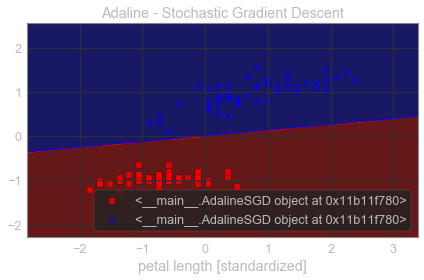

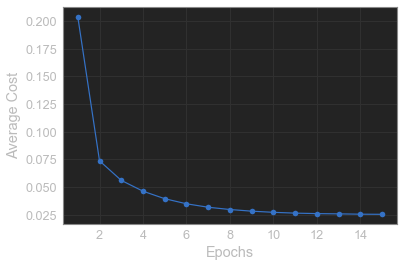

In [91]:
sgd = AdalineSGD(n_iter=15, eta=0.01, random_state=1)
sgd.fit(X_std, y)
plot_decision_regions(X_std, y, classifier=sgd)
plt.title('Adaline - Stochastic Gradient Descent')
plt.xlabel('sepal length [standardized]')
plt.xlabel('petal length [standardized]')
plt.legend(loc='best')
plt.tight_layout()
plt.show()
plt.plot(range(1, len(sgd.cost_) + 1), sgd.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Average Cost')
plt.show()